In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/deep_learning/HW4

/content/drive/.shortcut-targets-by-id/1v5fVXVsjR9cD7hVL0kK69N68E-Traw5Q/HW4


In [5]:
#!git clone https://github.com/amnghd/Persian_poems_corpus

In [6]:
from os import listdir
from os.path import isfile, join
from os import walk
from tqdm import tqdm
import pandas as pd
import collections
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.utils import shuffle
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
poets = ['jami','moulavi','bahar','salman','farrokhi','naserkhosro','vahshi','khajoo','asadi','saeb']
pomes_data = []
label = []

for i,p in enumerate(poets):
  data = open('Persian_poems_corpus/normalized/'+p+'_norm.txt').read()
  poems = data.lower().split("\n")[1:]
  for poem in poems:
    if len(poem)>6 and '  \t' != poem :
      pomes_data.append(poem)
      label.append(poets[i])
all_poems = pd.DataFrame({
                        "poem": pomes_data,
                     "poet": label})
all_poems.to_csv('poems.csv')

In [8]:
all_poems = pd.read_csv('poems.csv', usecols= ['poem','poet'])

### Handling Unbalanced Data

In [9]:
import plotly.graph_objects as go
fig = go.Figure()

groupby_label = all_poems.groupby('poet')['poet'].count()

fig.add_trace(go.Bar(
    x=list(groupby_label.index),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Again, for making things simple. We cut the dataset randomly based on the fewer label, the negative class.

In [10]:
all_poems = pd.read_csv('poems.csv', usecols= ['poem','poet'])
import numpy as np

min_lenght = 25000
for p in poets:
  indxs = all_poems.index[all_poems['poet'] == p].tolist()
  lenght = len(indxs)-min_lenght
  lenght = int((lenght+np.abs(lenght))/2)
  drop_indices = np.random.choice(indxs, lenght, replace=False)
  all_poems.drop(drop_indices,inplace=True)


In [11]:
fig = go.Figure()

groupby_label = all_poems.groupby('poet')['poet'].count()

fig.add_trace(go.Bar(
    x=list(groupby_label.index),
    y=groupby_label.tolist(),
    text=groupby_label.tolist()
))

fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [12]:
all_poems

,poem,poet
7,ورد دل حرز جان تمامست این,jami
8,پنج حرف است بس شگرف این اسم,jami
14,از پس این حروف فرخ فال,jami
18,زیر مشکین شعار یک یک حرف,jami
19,خفته حوران قاصرات الطرف,jami
...,...,...
303472,چنان در خانه آیینه محو دیدن خویشی,saeb
303473,که گر عالم شود زیر و زبر بیرون نمی آیی,saeb
303474,چشمی نچراندیم درین باغ چو شبنم,saeb
303475,چون سرو فشردیم قدم بر لب جویی,saeb


## Train,Validation,Test split

To achieve a globalized model, we need to split the cleaned dataset into train, valid, test sets due to size of the data. In this tutorial, I have considered a rate of **0.1** for both *valid*, *test* sets. For splitting, I use `train_test_split` provided by Sklearn package with stratifying on the label for preserving the distribution balance.

In [13]:
all_poems['poet_ids'] = all_poems['poet'].apply(lambda t: poets.index(t))

from sklearn.model_selection import train_test_split
train, test = train_test_split(all_poems, test_size=0.1, random_state=1, stratify=all_poems['poet'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['poet'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)
perplexity_set = test.sample(n=1000)

x_train, y_train = train['poem'].values.tolist(), train['poet_ids'].values.tolist()
x_valid, y_valid = valid['poem'].values.tolist(), valid['poet_ids'].values.tolist()
x_test, y_test = test['poem'].values.tolist(), test['poet_ids'].values.tolist()
x_perplexity, y_perplexity = perplexity_set['poem'].values.tolist(), perplexity_set['poet_ids'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)
print(perplexity_set.shape)

(175581, 3)
(19509, 3)
(21677, 3)
(1000, 3)


In [14]:
!pip install transformers
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00


### Configuration

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [16]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

EEVERY_EPOCH = 1000
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/model/bert-fa-base-uncased.bin'

import os
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [17]:
label2id = {label: i for i, label in enumerate(poets)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'jami': 0, 'moulavi': 1, 'bahar': 2, 'salman': 3, 'farrokhi': 4, 'naserkhosro': 5, 'vahshi': 6, 'khajoo': 7, 'asadi': 8, 'saeb': 9}
id2label: {0: 'jami', 1: 'moulavi', 2: 'bahar', 3: 'salman', 4: 'farrokhi', 5: 'naserkhosro', 6: 'vahshi', 7: 'khajoo', 8: 'asadi', 9: 'saeb'}


In [18]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })


### Input Embeddings

In [19]:
l = []
from tqdm import tqdm
for id in tqdm(range(len(all_poems))):
  sample_poem = all_poems.iloc[id]['poem']
  sample_label = all_poems.iloc[id]['poet']
  tokens = tokenizer.tokenize(sample_poem)
  l.append(len(tokens))
  
ll = np.array(l)
j = np.argmax(ll)
print(max(l))
MAX_LEN = max(l)+2

sample_poem = all_poems.iloc[j]['poem']
sample_label = all_poems.iloc[j]['poet']
tokens = tokenizer.tokenize(sample_poem)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Poet: {sample_poem}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

100%|██████████| 216767/216767 [01:48<00:00, 2003.42it/s]


15
  Poet: نه از خاکم و نه از بادم نه از آتش و نه از آبم
   Tokens: نه از خاکم و نه از بادم نه از اتش و نه از ابم
Token IDs: [3254, 2791, 4361, 2015, 1379, 3254, 2791, 23820, 3254, 2791, 4662, 1379, 3254, 2791, 51815]


In [20]:
encoding = tokenizer.encode_plus(
    sample_poem,
    max_length=MAX_LEN,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3254,  2791,  4361,  2015,  1379,  3254,  2791, 23820,  3254,
          2791,  4662,  1379,  3254,  2791, 51815,     4]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


### Dataset

In [21]:
class PoemseDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, poems, targets=None, poets=None, max_len=128):
        self.poems = poems
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {label: i for i, label in enumerate(poets)} if isinstance(poets, list) else {}
    
    def __len__(self):
        return len(self.poems)

    def __getitem__(self, item):
        poems = str(self.poems[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            poems,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'poem': poems,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, poets):
    dataset = PoemseDataset(
        poems=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        poets=poets)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [22]:

train_data_loader = create_data_loader(train['poem'].to_numpy(), train['poet'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, poets)
valid_data_loader = create_data_loader(valid['poem'].to_numpy(), valid['poet'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, poets)
test_data_loader = create_data_loader(test['poem'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, poets)
perplexity_data_loader = create_data_loader(perplexity_set['poem'].to_numpy(), perplexity_set['poet'].to_numpy(), tokenizer, MAX_LEN, TEST_BATCH_SIZE, poets)

In [23]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())


dict_keys(['poem', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])


In [24]:
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 10)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        
        pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [25]:


def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss


def eval_op(model, data_loader, loss_fn,epoch):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad(),tqdm(data_loader, total=len(data_loader)) as pbar:
        for i,dl in enumerate(pbar):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)


            outputs = model(input_ids,attention_mask,token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
            eval_y, _ = y_loss(y_true, y_pred, losses)
            eval_acc = acc_and_f1(eval_y[0], eval_y[1], average='weighted')['acc']
            pbar.set_description(f'VALID EPOCH : {epoch} - Loss: {sum(losses)/(i+1):.4f} - Accuracy: {eval_acc*100:.2f}%')
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


def train_op(model, data_loader, loss_fn, optimizer, scheduler,epoch):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    with tqdm(data_loader, total=len(data_loader)) as pbar:
       for i,dl in enumerate(pbar):

          input_ids = dl['input_ids']
          attention_mask = dl['attention_mask']
          token_type_ids = dl['token_type_ids']
          targets = dl['targets']

          input_ids = input_ids.to(device)
          attention_mask = attention_mask.to(device)
          token_type_ids = token_type_ids.to(device)
          targets = targets.to(device)

          optimizer.zero_grad()
          outputs = model(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids)
          
          _, preds = torch.max(outputs, dim=1)

          loss = loss_fn(outputs, targets)
          losses.append(loss.item())

          loss.backward()

          optimizer.step()
          scheduler.step()

          y_pred.extend(preds)
          y_true.extend(targets)
          train_y, _ = y_loss(y_true, y_pred, losses)
          train_acc = acc_and_f1(train_y[0], train_y[1], average='weighted')['acc']
          pbar.set_description(f'TRAIN EPOCH : {epoch} - Loss: {sum(losses)/(i+1):.4f} - Accuracy: {train_acc*100:.2f}%')

    train_y, train_loss = y_loss(y_true, y_pred, losses)
    
    return train_y, train_loss, eval_loss_min

In [26]:
def predict(model, comments, tokenizer, max_len=MAX_LEN, batch_size=TEST_BATCH_SIZE):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

# **PART A :**
Train a model just by train classifier model.

In [27]:
A_model = SentimentModel(config).to(device)
print('pt_model', type(A_model))

for param in A_model.parameters():
    param.requires_grad = False

params_to_update = []
for name,param in A_model.named_parameters():
    if 'classifier' in name or 'pooler' in name:
        param.requires_grad = True
        params_to_update.append(param)
        print("\t",name)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>
	 bert.pooler.dense.weight
	 bert.pooler.dense.bias
	 classifier.weight
	 classifier.bias


In [28]:
sample_data_poem = sample_data['poem']
sample_data_input_ids = sample_data['input_ids'].to(device)
sample_data_attention_mask = sample_data['attention_mask'].to(device)
sample_data_token_type_ids = sample_data['token_type_ids'].to(device)
sample_data_targets = sample_data['targets'].to(device)

outputs = A_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

In [29]:
EPOCHS = 5
LEARNING_RATE = 1e-4

In [30]:
A_model.load_state_dict(torch.load("Poet_classification_last_layer_tune.pth"),strict = False)

<All keys matched successfully>

In [31]:
optimizer = torch.optim.AdamW(params_to_update, lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()
eval_loss_min = np.Inf
history = collections.defaultdict(list)

In [ ]:
ls = []
for epoch in range(1, EPOCHS + 1):
  
    train_y, train_loss, eval_loss_min = train_op(A_model, train_data_loader, loss_fn, optimizer, scheduler,epoch)

    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(A_model, valid_data_loader, loss_fn,epoch)
    ls.append(eval_loss)
    if (ls[-1]==min(ls)):
          torch.save(A_model.state_dict(), 'Poet_classification_last_layer_tune.pth')
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

In [32]:
test_poems = test['poem'].to_numpy()
preds, probs = predict(A_model, test_poems, tokenizer, max_len=MAX_LEN)

100%|██████████| 339/339 [00:21<00:00, 16.09it/s]


In [33]:
y_test, y_pred = [poets.index(label) for label in test['poet'].values], list(preds)
print(f'F1 score: {f1_score(y_test, y_pred, average="weighted"):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'Loss: {loss_fn(torch.tensor(probs),torch.tensor(y_test)).item()}')
print()
print(classification_report(y_test, y_pred, target_names=poets))

F1 score: 0.3778
Accuracy: 38.52%
Loss: 2.176252603530884

              precision    recall  f1-score   support

        jami       0.40      0.40      0.40      2500
     moulavi       0.41      0.39      0.40      2500
       bahar       0.35      0.23      0.28      2500
      salman       0.34      0.33      0.34      2500
    farrokhi       0.40      0.50      0.45      2397
 naserkhosro       0.39      0.41      0.40      2150
      vahshi       0.29      0.18      0.22      2099
      khajoo       0.35      0.45      0.39      1769
       asadi       0.44      0.55      0.49      1762
        saeb       0.42      0.49      0.45      1500

    accuracy                           0.39     21677
   macro avg       0.38      0.39      0.38     21677
weighted avg       0.38      0.39      0.38     21677



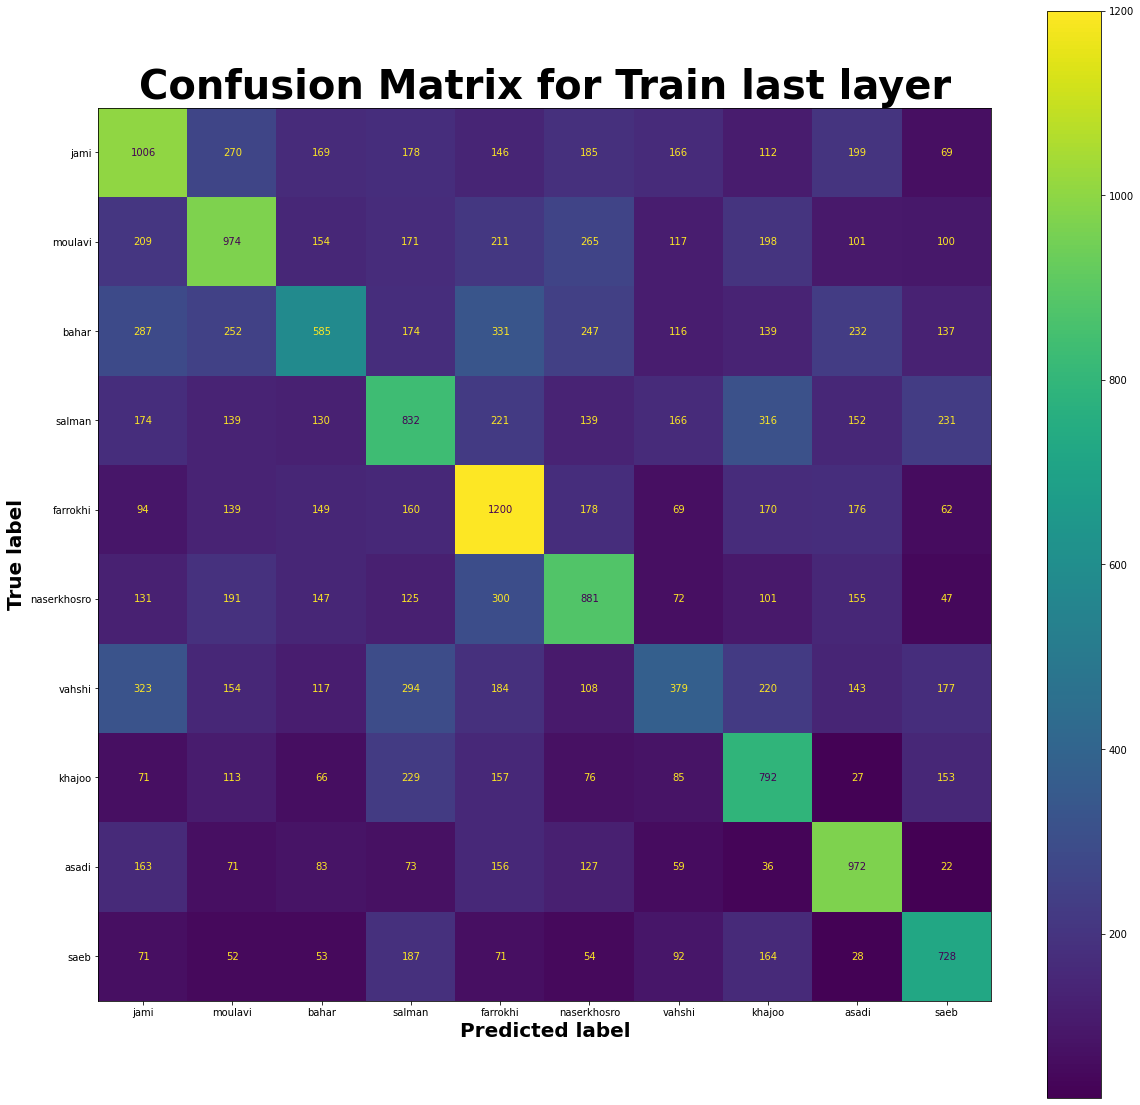

In [34]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=poets)
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Confusion Matrix for Train last layer',fontweight="bold", size=40)
ax.set_ylabel('Pred',fontweight="bold", fontsize = 20.0)
ax.set_xlabel('True',fontweight="bold", fontsize = 20) 
disp.plot(ax=ax)


# **PART B1 :**
Fine-tune whole model, by adam algorithm

In [35]:
perplexity = [0,0,0]

In [36]:
pt_model = SentimentModel(config).to(device)
print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [37]:
sample_data_poem = sample_data['poem']
sample_data_input_ids = sample_data['input_ids'].to(device)
sample_data_attention_mask = sample_data['attention_mask'].to(device)
sample_data_token_type_ids = sample_data['token_type_ids'].to(device)
sample_data_targets = sample_data['targets'].to(device)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

In [38]:
EPOCHS = 10
LEARNING_RATE = 1e-4

In [41]:
optimizer = torch.optim.Adam(pt_model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()
eval_loss_min = np.Inf
history = collections.defaultdict(list)
_, perple_loss = eval_op(pt_model, perplexity_data_loader, loss_fn,1)
perplexity[0] = (torch.exp(torch.tensor(perple_loss)))

VALID EPOCH : 1 - Loss: 2.4293 - Accuracy: 8.20%: 100%|██████████| 16/16 [00:01<00:00,  9.60it/s]


In [42]:
pt_model.load_state_dict(torch.load("Poet_classification_Adam_finetune.pth"),strict = False)

<All keys matched successfully>

In [ ]:
ls = []
for epoch in range(1, EPOCHS + 1):
    train_y, train_loss, eval_loss_min = train_op(pt_model, train_data_loader, loss_fn, optimizer, scheduler,epoch)
    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    eval_y, eval_loss = eval_op(pt_model, valid_data_loader, loss_fn,epoch)
    ls.append(eval_loss)
    if (ls[-1]==min(ls)):
          torch.save(pt_model.state_dict(), 'Poet_classification_Adam_finetune.pth')
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

### Prediction

In [43]:
test_poems = test['poem'].to_numpy()
preds, probs = predict(pt_model, test_poems, tokenizer, max_len=MAX_LEN)

print(preds.shape, probs.shape)

100%|██████████| 339/339 [00:23<00:00, 14.30it/s]

(21677,) (21677, 10)


In [46]:
y_test, y_pred = [poets.index(label) for label in test['poet'].values], list(preds)
print(f'F1 score: {f1_score(y_test, y_pred, average="weighted"):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
loss_last = loss_fn(torch.tensor(probs),torch.tensor(y_test)).item()
print(f'Loss: {loss_last}')
print()
print(classification_report(y_test, y_pred, target_names=poets))

_, perple_loss = eval_op(pt_model, perplexity_data_loader, loss_fn,1)
perplexity[1] = (torch.exp(torch.tensor(perple_loss)))

F1 score: 0.6534
Accuracy: 65.59%
Loss: 1.8728305101394653

              precision    recall  f1-score   support

        jami       0.59      0.72      0.65      2500
     moulavi       0.74      0.75      0.75      2500
       bahar       0.63      0.58      0.60      2500
      salman       0.62      0.62      0.62      2500
    farrokhi       0.69      0.75      0.72      2397
 naserkhosro       0.66      0.60      0.63      2150
      vahshi       0.50      0.45      0.48      2099
      khajoo       0.66      0.62      0.64      1769
       asadi       0.72      0.86      0.78      1762
        saeb       0.81      0.58      0.68      1500

    accuracy                           0.66     21677
   macro avg       0.66      0.65      0.65     21677
weighted avg       0.66      0.66      0.65     21677



VALID EPOCH : 1 - Loss: 0.9854 - Accuracy: 67.90%: 100%|██████████| 16/16 [00:01<00:00,  9.42it/s]


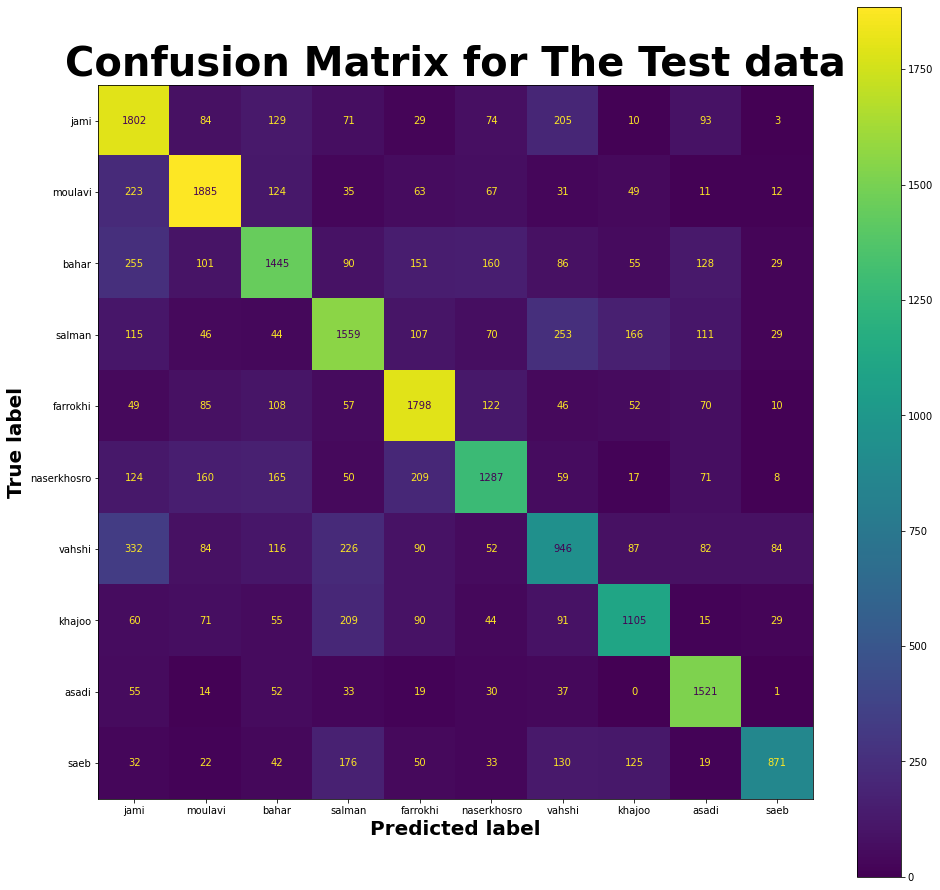

In [47]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=poets)
fig, ax = plt.subplots(figsize=(16,16))
ax.set_title('Confusion Matrix for The Test data',fontweight="bold", size=40)
ax.set_ylabel('YLabel',fontweight="bold", fontsize = 20.0)
ax.set_xlabel('XLabel',fontweight="bold", fontsize = 20) 
disp.plot(ax=ax)


# **PART B2 :**
Fine-tune whole model, by SGD algorithm

In [48]:
pt_model = SentimentModel(config).to(device)
print('pt_model', type(pt_model))

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pt_model <class '__main__.SentimentModel'>


In [49]:
sample_data_poem = sample_data['poem']
sample_data_input_ids = sample_data['input_ids'].to(device)
sample_data_attention_mask = sample_data['attention_mask'].to(device)
sample_data_token_type_ids = sample_data['token_type_ids'].to(device)
sample_data_targets = sample_data['targets'].to(device)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

In [50]:
EPOCHS = 2
LEARNING_RATE = 2e-4

In [51]:
import collections
optimizer = torch.optim.SGD(pt_model.parameters(), lr=LEARNING_RATE,momentum = 0.9)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()
eval_loss_min = np.Inf
history = collections.defaultdict(list)

In [52]:
pt_model.load_state_dict(torch.load("Poet_classification_SGD_finetune.pth"),strict = False)

<All keys matched successfully>

In [ ]:
ls = []
for epoch in range(1, EPOCHS + 1):
  
    train_y, train_loss, eval_loss_min = train_op(pt_model, train_data_loader, loss_fn, optimizer, scheduler,epoch)

    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
    
    eval_y, eval_loss = eval_op(pt_model, valid_data_loader, loss_fn,epoch)
    ls.append(eval_loss)
    if (ls[-1]==min(ls)):
          torch.save(pt_model.state_dict(), 'Poet_classification_SGD_finetune.pth')
    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
    
    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

### Prediction

In [53]:
test_poems = test['poem'].to_numpy()
preds, probs = predict(pt_model, test_poems, tokenizer, max_len=MAX_LEN)

print(preds.shape, probs.shape)

100%|██████████| 339/339 [00:23<00:00, 14.26it/s]

(21677,) (21677, 10)


In [54]:
y_test, y_pred = [poets.index(label) for label in test['poet'].values], list(preds)
print(f'F1 score: {f1_score(y_test, y_pred, average="weighted"):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
loss_last = loss_fn(torch.tensor(probs),torch.tensor(y_test)).item()
print(f'Loss: {loss_last}')
print()
print(classification_report(y_test, y_pred, target_names=poets))

_, perple_loss = eval_op(pt_model, perplexity_data_loader, loss_fn,1)
perplexity[2] = (torch.exp(torch.tensor(perple_loss)))

F1 score: 0.6440
Accuracy: 64.82%
Loss: 1.8813740015029907

              precision    recall  f1-score   support

        jami       0.60      0.69      0.64      2500
     moulavi       0.70      0.76      0.73      2500
       bahar       0.60      0.50      0.54      2500
      salman       0.59      0.62      0.60      2500
    farrokhi       0.72      0.74      0.73      2397
 naserkhosro       0.68      0.61      0.64      2150
      vahshi       0.49      0.40      0.44      2099
      khajoo       0.68      0.65      0.66      1769
       asadi       0.74      0.84      0.79      1762
        saeb       0.68      0.74      0.71      1500

    accuracy                           0.65     21677
   macro avg       0.65      0.65      0.65     21677
weighted avg       0.64      0.65      0.64     21677



VALID EPOCH : 1 - Loss: 1.0391 - Accuracy: 64.50%: 100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


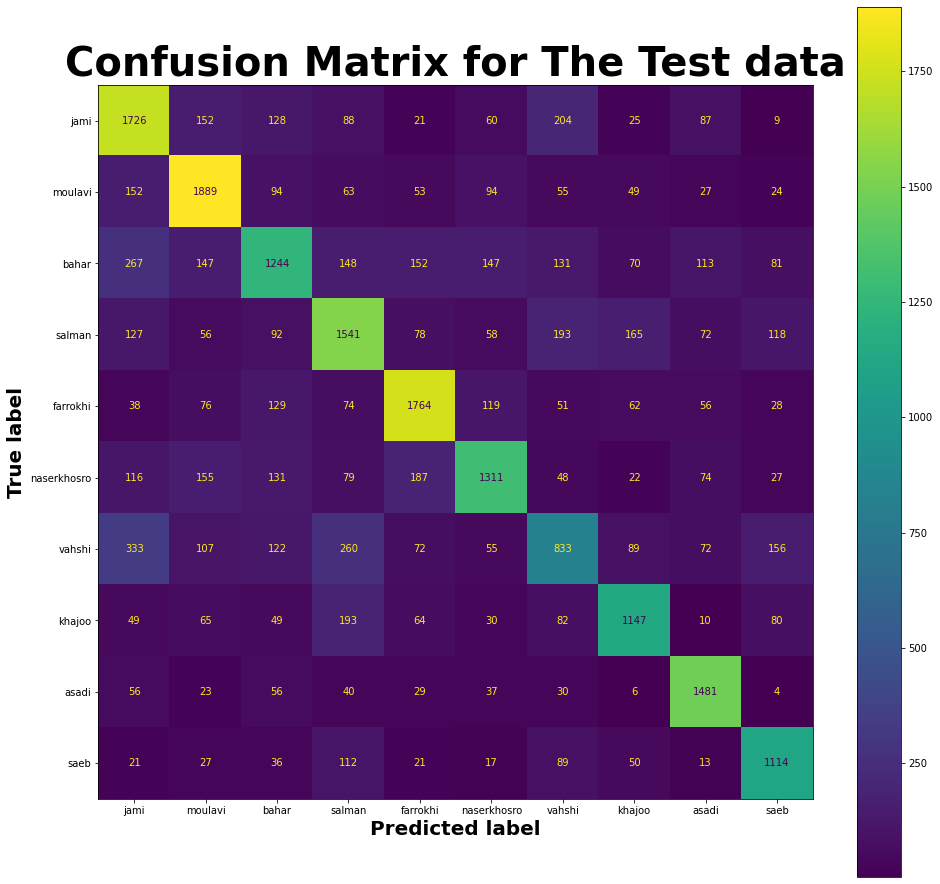

In [57]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=poets)
fig, ax = plt.subplots(figsize=(16,16))
ax.set_title('Confusion Matrix for The Test data',fontweight="bold", size=40)
ax.set_ylabel('YLabel',fontweight="bold", fontsize = 20.0)
ax.set_xlabel('XLabel',fontweight="bold", fontsize = 20) 
disp.plot(ax=ax)


# **PART C**
Calculate and show the Perplexity of the model before and after fine-tuning

In [56]:
print(f'Perplexity of model before fine-tune: {perplexity[0]:.3f}')
print(f'Perplexity of model after fine-tune by ADAM algorithm: {perplexity[1]:.3f}')
print(f'Perplexity of model after fine-tune by SGD algorithm: {perplexity[2]:.3f}')

Perplexity of model before fine-tune: 11.350
Perplexity of model after fine-tune by ADAM algorithm: 2.679
Perplexity of model after fine-tune by SGD algorithm: 2.827
